## Import Libs

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tensorflow
import sklearn as sklearn
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

df_train = pd.read_csv('./UNSW_NB15_training-set.csv/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('./UNSW_NB15_testing-set.csv/UNSW_NB15_testing-set.csv')

## Check Data

In [18]:
df_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

## Data Scrubbing


drop id, attack_cat(we only need label since it's binary classification, 0: non-attack/1: attack)

In [20]:
df_train = df_train.drop(columns=['id', 'attack_cat'], axis = 1)
df_test = df_test.drop(columns=['id', 'attack_cat'], axis = 1)

Turn object to numeric classification(proto, service, state)

In [21]:
df_train['proto'] = LabelEncoder().fit_transform(df_train['proto'])
df_train['service'] = LabelEncoder().fit_transform(df_train['service'])
df_train['state'] = LabelEncoder().fit_transform(df_train['state'])
df_test['proto'] = LabelEncoder().fit_transform(df_test['proto'])
df_test['service'] = LabelEncoder().fit_transform(df_test['service'])
df_test['state'] = LabelEncoder().fit_transform(df_test['state'])
print(df_train['proto'])
print(df_train['service'])
print(df_train['state'])

0        117
1        117
2        117
3        117
4        117
        ... 
82327    117
82328    111
82329      6
82330      6
82331    117
Name: proto, Length: 82332, dtype: int32
0        0
1        0
2        0
3        0
4        0
        ..
82327    0
82328    0
82329    0
82330    0
82331    0
Name: service, Length: 82332, dtype: int32
0        4
1        4
2        4
3        4
4        4
        ..
82327    4
82328    3
82329    4
82330    4
82331    4
Name: state, Length: 82332, dtype: int32


Show Correlation

<AxesSubplot: >

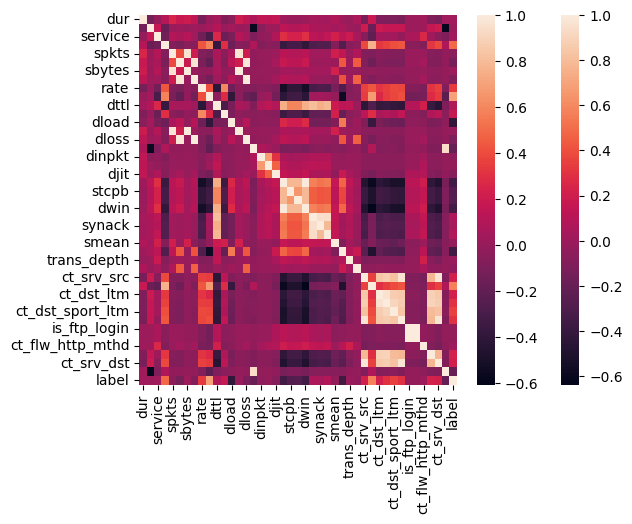

In [22]:
sns.heatmap(df_train.corr())
sns.heatmap(df_test.corr())

Split into X and Y

In [23]:
X_train = pd.DataFrame(df_train).drop(columns=['label'])
X_test = pd.DataFrame(df_test).drop(columns=['label'])
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = df_train['label']
y_test = df_test['label']

Normalize data for equal weight

In [24]:
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)

scale = StandardScaler().fit(X_test)
X_test = scale.transform(X_test)

## Training prep

Callback function to stop overfitting and save resources

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

Plotting function

In [26]:
def show_acc(history, e):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.plot(history.history['mae'], label='mae')
  plt.plot(history.history['val_mae'], label='val_mae')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy/MAE')
  plt.legend()
  plt.show()


Model template

In [27]:
def build_model(neurons, layers, input_shape, activation='linear', regularizer=None, lam=0.01, dropout=False, drop_prob=0.2, summarize=False):
  model = Sequential()
  model.add(Flatten(input_shape=input_shape))
  if regularizer != None:
    for i in range(layers-1):
      model.add(Dense(neurons, activation=activation, kernel_regularizer=regularizer(lam)))
      if dropout:
        model.add(Dropout(0.2))
  else:
    model.add(Dense(neurons, input_shape=input_shape))
    for i in range(layers-1):
      model.add(Dense(neurons, activation=activation))

  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='mae', optimizer='adam', metrics=['accuracy','mae'])

  if summarize:
    model.build()
    model.summary()
    
  return model

Final form

In [28]:
def build_and_plot(neurons, layers, input_shape, activation='linear', regularizer=None, lam=0.01, dropout=False, drop_prob=0.2, summarize=False, e=100, verbose=0):
  model = build_model(neurons, layers, input_shape, activation=activation, regularizer=regularizer, lam=lam, dropout=dropout, drop_prob=drop_prob, summarize=summarize)
  history = model.fit(X_train, y_train, epochs=e, validation_data=(X_test, y_test), verbose=verbose, callbacks=[early_stopping])
  #history = model.fit(X_train, y_train, epochs=e, validation_data=(X_test, y_test), verbose=verbose)
  show_acc(history, e)
  print("Max mae: ", np.max(history.history['mae']))
  print("Min mae: ", np.min(history.history['mae']))
  print("Test MAE: ", model.evaluate(X_test, y_test))
  print("Accuracy: ", np.max(history.history['accuracy']))

## Base model w/o regularizers or activation

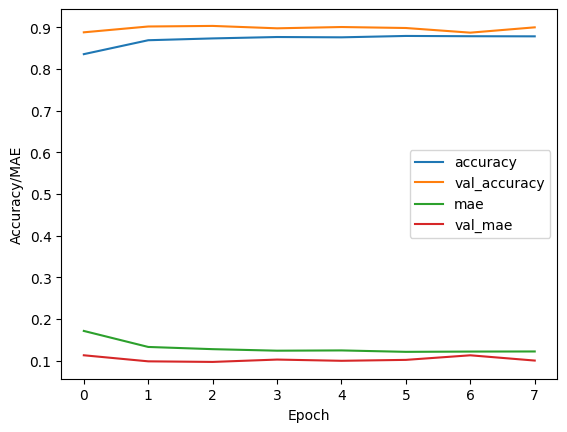

Max mae:  0.17135116457939148
Min mae:  0.12119650095701218
5480/5480 [==============================] - 28s 5ms/step - loss: 0.1003 - accuracy: 0.8997 - mae: 0.1003
Test MAE:  [0.10028770565986633, 0.899686872959137, 0.10028770565986633]
Accuracy:  0.8790385127067566


In [29]:
build_and_plot(neurons=4, layers=4, input_shape=(X_train.shape[1],), e=10, verbose=0)

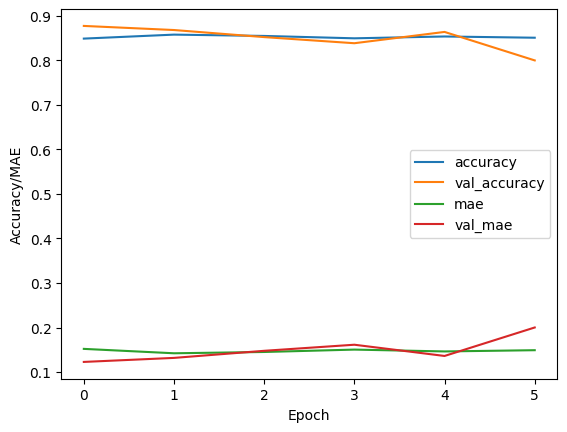

Max mae:  0.1521223485469818
Min mae:  0.142243891954422
5480/5480 [==============================] - 14s 3ms/step - loss: 0.2002 - accuracy: 0.7999 - mae: 0.2002
Test MAE:  [0.2001660168170929, 0.7998756766319275, 0.2001660168170929]
Accuracy:  0.8577831387519836


In [30]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), e=100, verbose=0)

## With different activations

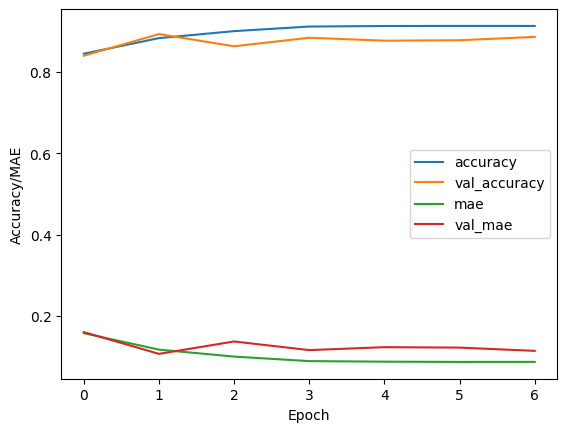

Max mae:  0.15802134573459625
Min mae:  0.08742282539606094
5480/5480 [==============================] - 23s 4ms/step - loss: 0.1146 - accuracy: 0.8856 - mae: 0.1146
Test MAE:  [0.11460154503583908, 0.8856228590011597, 0.11460154503583908]
Accuracy:  0.9126099348068237


In [31]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), activation='sigmoid', dropout=False, e=100, verbose=0)

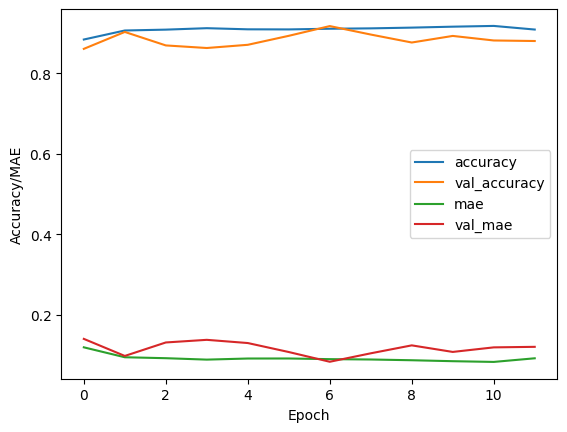

Max mae:  0.1187979057431221
Min mae:  0.08252517133951187
5480/5480 [==============================] - 18s 3ms/step - loss: 0.1200 - accuracy: 0.8800 - mae: 0.1200
Test MAE:  [0.12001258879899979, 0.8799881339073181, 0.12001258879899979]
Accuracy:  0.9174925684928894


In [32]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), activation='relu', dropout=False, e=100, verbose=0)

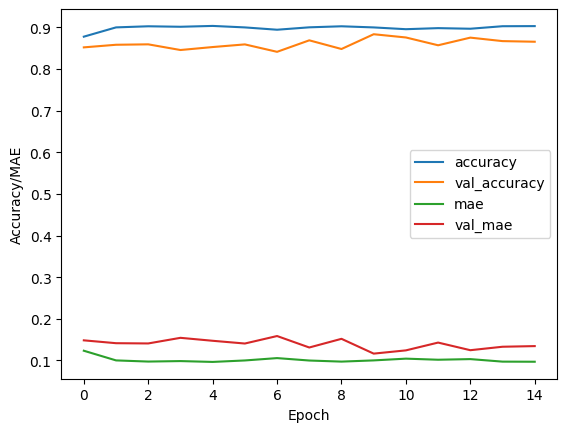

Max mae:  0.12317755073308945
Min mae:  0.09628447145223618
5480/5480 [==============================] - 12s 2ms/step - loss: 0.1343 - accuracy: 0.8657 - mae: 0.1343
Test MAE:  [0.13431037962436676, 0.8657416105270386, 0.13431037962436676]
Accuracy:  0.9037312269210815


In [33]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=False, e=100, verbose=0)

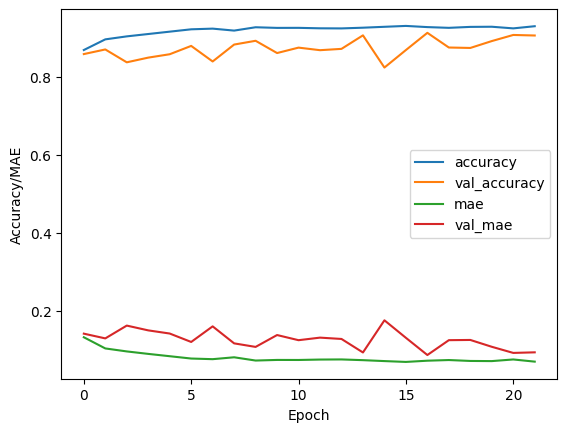

Max mae:  0.1319965422153473
Min mae:  0.06866908818483353
5480/5480 [==============================] - 23s 4ms/step - loss: 0.0933 - accuracy: 0.9068 - mae: 0.0933
Test MAE:  [0.09328237920999527, 0.906775951385498, 0.09328237920999527]
Accuracy:  0.9313753843307495


In [34]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), activation='tanh', dropout=False, e=100, verbose=0)

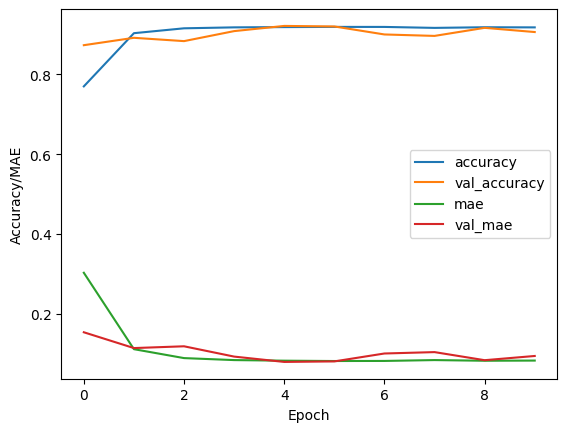

Max mae:  0.30239859223365784
Min mae:  0.0809074342250824
5480/5480 [==============================] - 11s 2ms/step - loss: 0.0936 - accuracy: 0.9066 - mae: 0.0936
Test MAE:  [0.0935744047164917, 0.9065535068511963, 0.0935744047164917]
Accuracy:  0.9194723963737488


In [35]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), activation='softmax', dropout=False, e=100, verbose=0)

## With Regularizers + most accurate activator

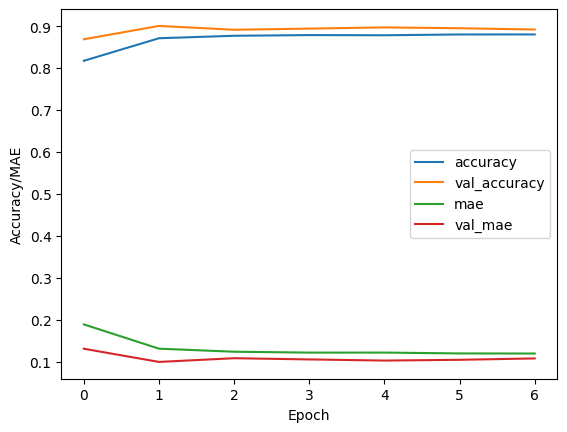

Max mae:  0.1893911212682724
Min mae:  0.11997617781162262
5480/5480 [==============================] - 6s 1ms/step - loss: 0.1083 - accuracy: 0.8919 - mae: 0.1083
Test MAE:  [0.10827992111444473, 0.8918678164482117, 0.10827992111444473]
Accuracy:  0.8801802396774292


In [47]:
build_and_plot(neurons=4, layers=4, input_shape=(X_train.shape[1],), dropout=True, e=10, verbose=0)

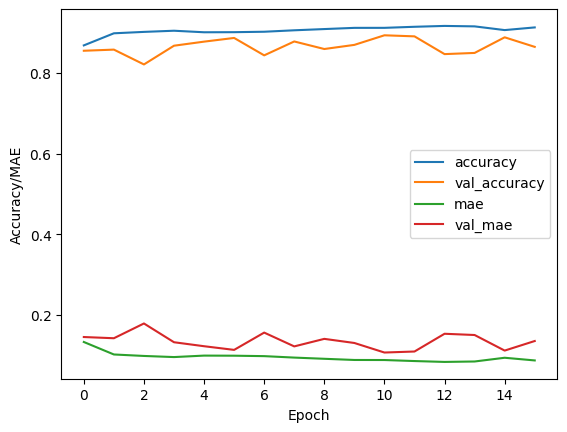

Max mae:  0.13317374885082245
Min mae:  0.08378300070762634
5480/5480 [==============================] - 5s 967us/step - loss: 0.1356 - accuracy: 0.8644 - mae: 0.1356
Test MAE:  [0.13558483123779297, 0.8643728494644165, 0.13558483123779297]
Accuracy:  0.9162658452987671


In [46]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), dropout=True, activation='tanh', e=100, verbose=0)

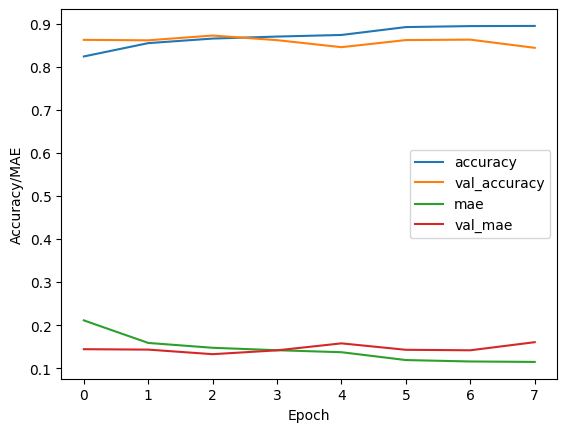

Max mae:  0.21107812225818634
Min mae:  0.11457996815443039
5480/5480 [==============================] - 23s 4ms/step - loss: 0.2301 - accuracy: 0.8440 - mae: 0.1604
Test MAE:  [0.2300872802734375, 0.8439782857894897, 0.1604175567626953]
Accuracy:  0.8948161005973816


In [42]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l1, dropout=False, activation='tanh', e=100, verbose=0)

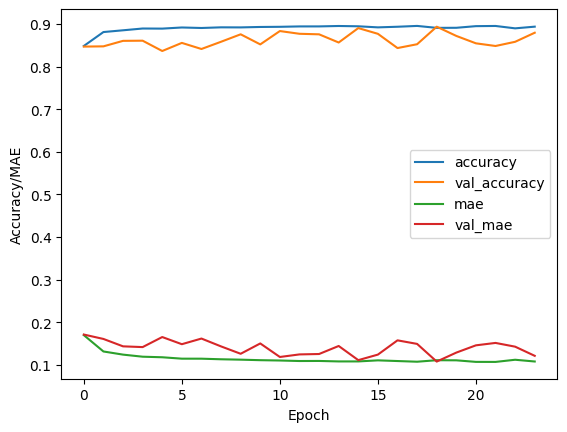

Max mae:  0.16953270137310028
Min mae:  0.10662440955638885
5480/5480 [==============================] - 10s 2ms/step - loss: 0.1395 - accuracy: 0.8796 - mae: 0.1209
Test MAE:  [0.13952919840812683, 0.8795660734176636, 0.1209283247590065]
Accuracy:  0.8955448865890503


In [43]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=100, verbose=0)

Regularizers with dropout

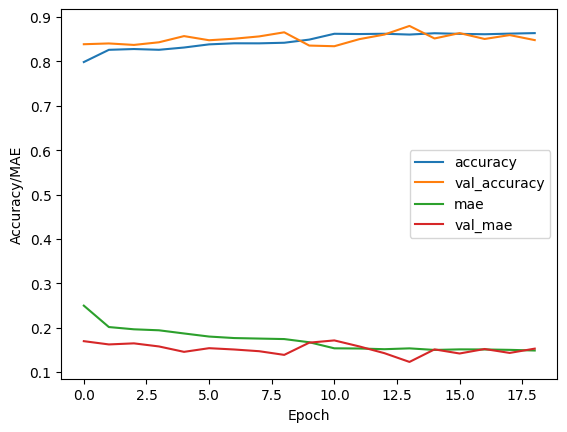

Max mae:  0.2497236728668213
Min mae:  0.14863736927509308
5480/5480 [==============================] - 14s 2ms/step - loss: 0.2416 - accuracy: 0.8478 - mae: 0.1529
Test MAE:  [0.2416018396615982, 0.8478222489356995, 0.15288375318050385]
Accuracy:  0.8635767102241516


In [44]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l1, dropout=True, activation='tanh', e=100, verbose=0)

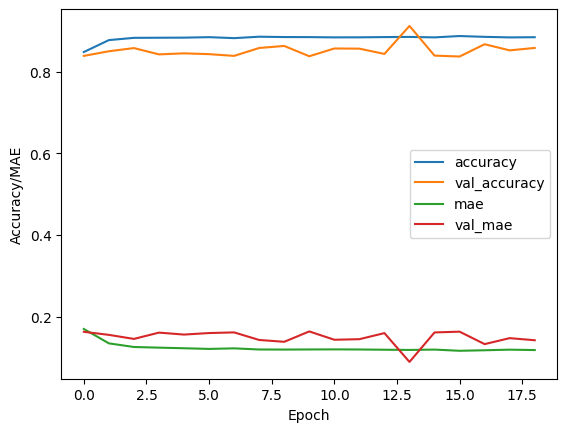

Max mae:  0.17029888927936554
Min mae:  0.116841621696949
5480/5480 [==============================] - 6s 1ms/step - loss: 0.1686 - accuracy: 0.8582 - mae: 0.1426
Test MAE:  [0.16860264539718628, 0.8582191467285156, 0.1426413506269455]
Accuracy:  0.8873220682144165


In [45]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=True, activation='tanh', e=100, verbose=0)

Differ by Neuron

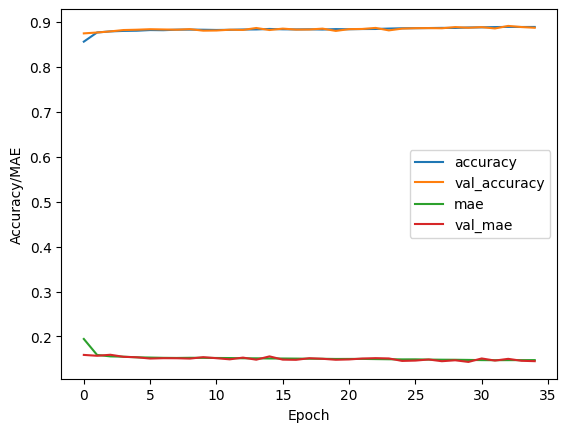

Max mae:  0.19445516169071198
Min mae:  0.14720717072486877
2573/2573 [==============================] - 3s 1ms/step - loss: 0.1696 - accuracy: 0.8869 - mae: 0.1450
Test MAE:  [0.16955409944057465, 0.8869455456733704, 0.14504525065422058]
Accuracy:  0.8888888955116272


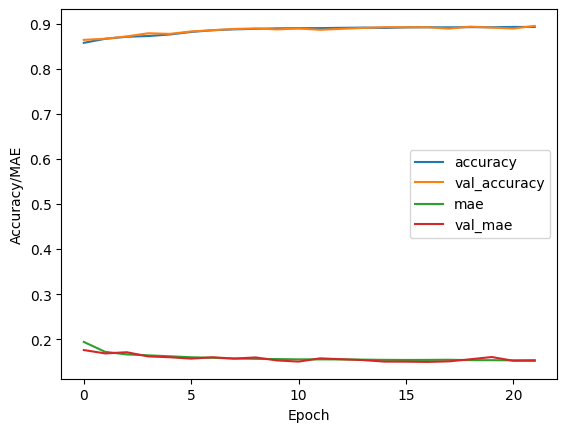

Max mae:  0.19396546483039856
Min mae:  0.1531914323568344
2573/2573 [==============================] - 2s 954us/step - loss: 0.1719 - accuracy: 0.8951 - mae: 0.1522
Test MAE:  [0.17185962200164795, 0.8950711488723755, 0.15215131640434265]
Accuracy:  0.8928241729736328


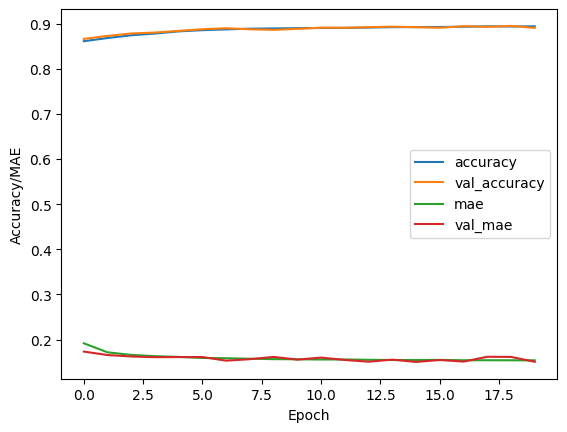

Max mae:  0.19176536798477173
Min mae:  0.1539992094039917
2573/2573 [==============================] - 3s 1ms/step - loss: 0.1710 - accuracy: 0.8903 - mae: 0.1508
Test MAE:  [0.17095120251178741, 0.8903220891952515, 0.1507975459098816]
Accuracy:  0.8939294815063477


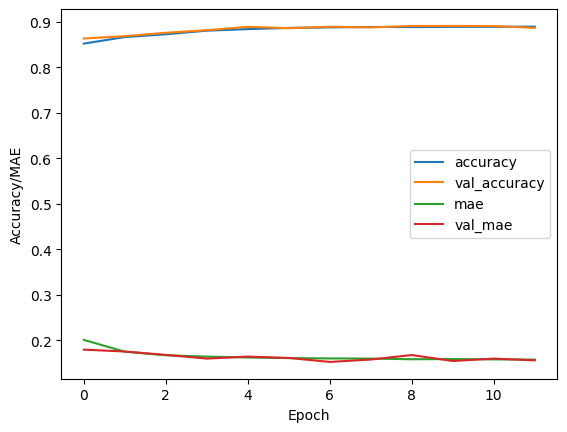

Max mae:  0.20114590227603912
Min mae:  0.15791098773479462
2573/2573 [==============================] - 3s 1ms/step - loss: 0.1791 - accuracy: 0.8862 - mae: 0.1562
Test MAE:  [0.17910678684711456, 0.8862289190292358, 0.15618662536144257]
Accuracy:  0.8889131546020508


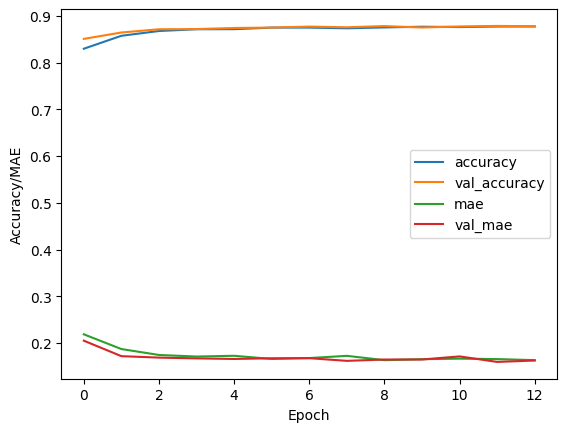

Max mae:  0.2186577469110489
Min mae:  0.16336382925510406
2573/2573 [==============================] - 7s 3ms/step - loss: 0.1895 - accuracy: 0.8776 - mae: 0.1626
Test MAE:  [0.18954670429229736, 0.8776174783706665, 0.16262289881706238]
Accuracy:  0.8771194815635681


In [ ]:
build_and_plot(neurons=8, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=100, verbose=0)
build_and_plot(neurons=32, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=100, verbose=0)
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=100, verbose=0)
build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=100, verbose=0)
build_and_plot(neurons=512, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=100, verbose=0)

Differ by Layer

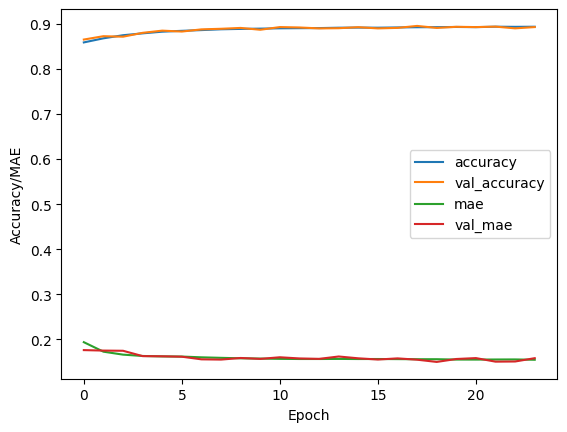

Max mae:  0.19364486634731293
Min mae:  0.15462109446525574
2573/2573 [==============================] - 2s 869us/step - loss: 0.1784 - accuracy: 0.8930 - mae: 0.1581
Test MAE:  [0.17836321890354156, 0.8930063843727112, 0.15812698006629944]
Accuracy:  0.8938444256782532


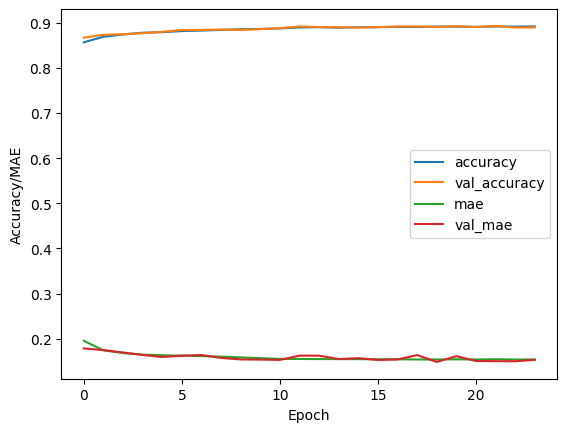

Max mae:  0.1952521800994873
Min mae:  0.15385587513446808
2573/2573 [==============================] - 3s 1ms/step - loss: 0.2006 - accuracy: 0.8898 - mae: 0.1531
Test MAE:  [0.20058304071426392, 0.8897512555122375, 0.15312431752681732]
Accuracy:  0.8918768167495728


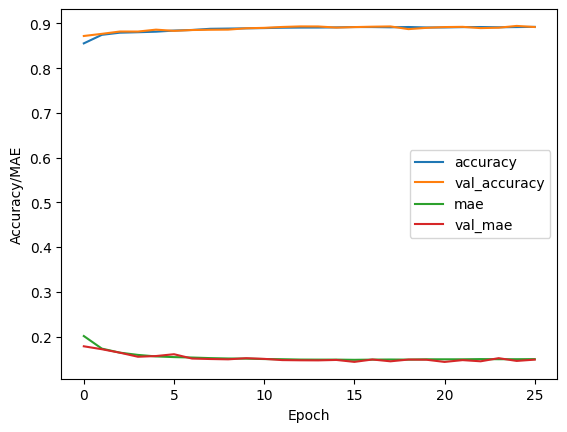

Max mae:  0.2012222856283188
Min mae:  0.14805234968662262
2573/2573 [==============================] - 3s 1ms/step - loss: 0.2748 - accuracy: 0.8919 - mae: 0.1485
Test MAE:  [0.27483731508255005, 0.8919132351875305, 0.1484939455986023]
Accuracy:  0.8922775983810425


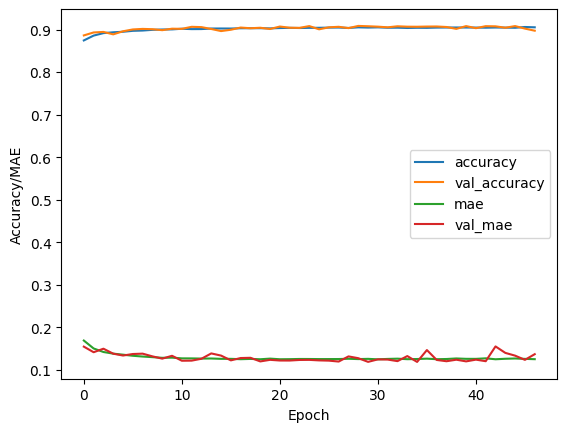

Max mae:  0.16884028911590576
Min mae:  0.12464822828769684
2573/2573 [==============================] - 5s 2ms/step - loss: 0.4262 - accuracy: 0.8972 - mae: 0.1367
Test MAE:  [0.4262270927429199, 0.8972331285476685, 0.13674339652061462]
Accuracy:  0.9059661030769348


In [ ]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=100, verbose=0)
build_and_plot(neurons=64, layers=8, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=100, verbose=0)
build_and_plot(neurons=64, layers=16, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=100, verbose=0)
build_and_plot(neurons=64, layers=32, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=100, verbose=0)

Differ by Lambda

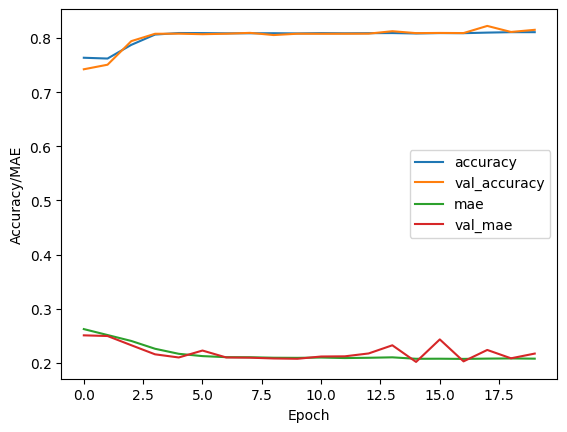

Max mae:  0.26227954030036926
Min mae:  0.2072266787290573
2573/2573 [==============================] - 2s 865us/step - loss: 0.2548 - accuracy: 0.8152 - mae: 0.2170
Test MAE:  [0.25476521253585815, 0.8152480125427246, 0.2170499712228775]
Accuracy:  0.8108876347541809


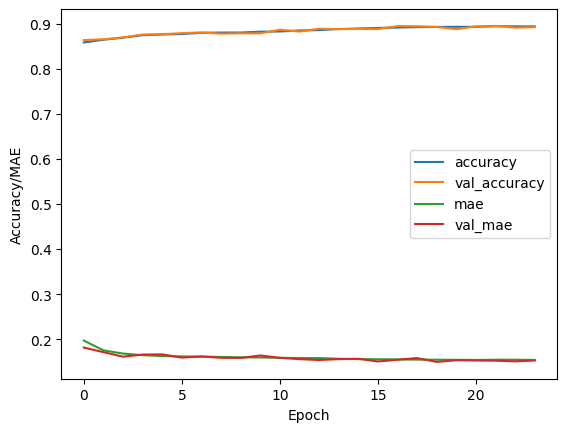

Max mae:  0.19688645005226135
Min mae:  0.15383842587471008
2573/2573 [==============================] - 2s 925us/step - loss: 0.1731 - accuracy: 0.8926 - mae: 0.1527
Test MAE:  [0.1730707436800003, 0.8926177024841309, 0.15272702276706696]
Accuracy:  0.894633948802948


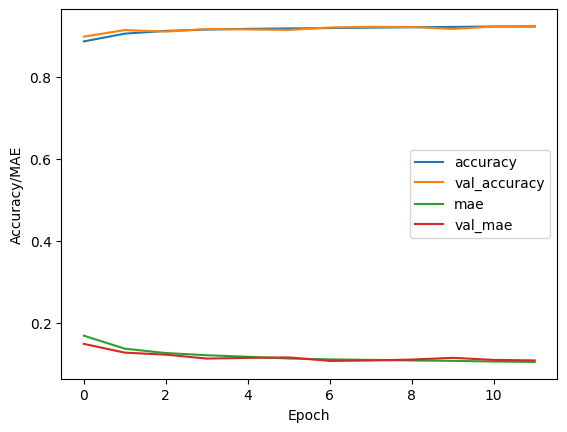

Max mae:  0.168742835521698
Min mae:  0.10480643808841705
2573/2573 [==============================] - 2s 912us/step - loss: 0.1370 - accuracy: 0.9232 - mae: 0.1085
Test MAE:  [0.13697420060634613, 0.9232133030891418, 0.10849978029727936]
Accuracy:  0.9218044281005859


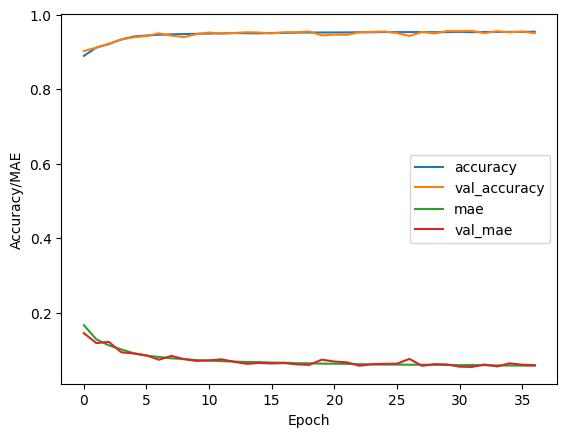

Max mae:  0.16635575890541077
Min mae:  0.05718778073787689
2573/2573 [==============================] - 4s 2ms/step - loss: 0.0731 - accuracy: 0.9505 - mae: 0.0589
Test MAE:  [0.07312670350074768, 0.950505256652832, 0.058870941400527954]
Accuracy:  0.9545012712478638


In [ ]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', lam=0.1, e=100, verbose=0)
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', lam=0.01, e=100, verbose=0)
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', lam=0.001, e=100, verbose=0)
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', lam=0.0001, e=100, verbose=0)

Differ by Dropout Probability

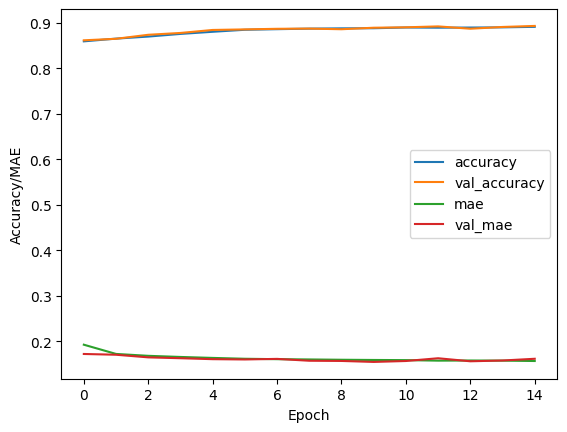

Max mae:  0.19222475588321686
Min mae:  0.15633061528205872
2573/2573 [==============================] - 2s 827us/step - loss: 0.1828 - accuracy: 0.8934 - mae: 0.1613
Test MAE:  [0.18280228972434998, 0.8933707475662231, 0.16125018894672394]
Accuracy:  0.8913666605949402


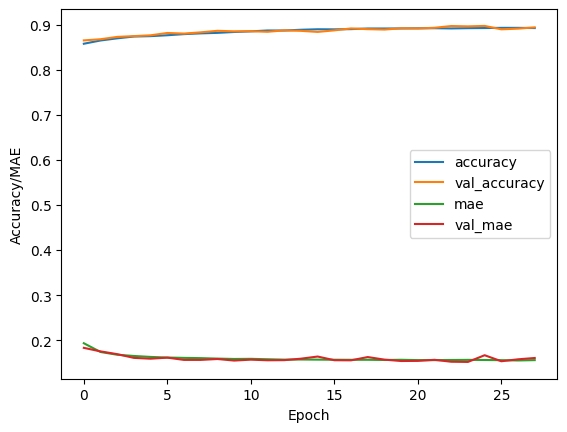

Max mae:  0.19312722980976105
Min mae:  0.1548280566930771
2573/2573 [==============================] - 3s 1ms/step - loss: 0.1796 - accuracy: 0.8949 - mae: 0.1603
Test MAE:  [0.1795782595872879, 0.8949011564254761, 0.16033883392810822]
Accuracy:  0.8937715888023376


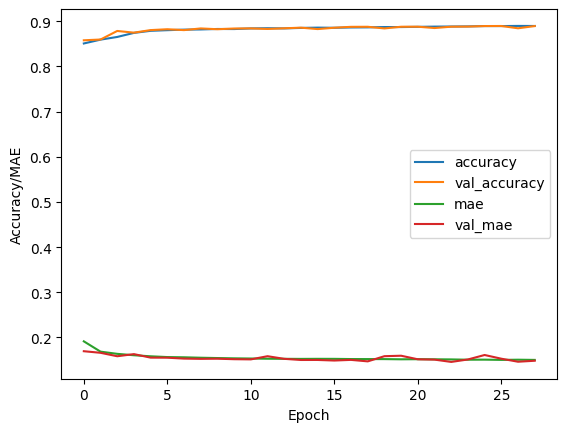

Max mae:  0.1914510577917099
Min mae:  0.15036068856716156
2573/2573 [==============================] - 3s 1ms/step - loss: 0.1728 - accuracy: 0.8894 - mae: 0.1485
Test MAE:  [0.17277872562408447, 0.8893625736236572, 0.14850451052188873]
Accuracy:  0.8896540999412537


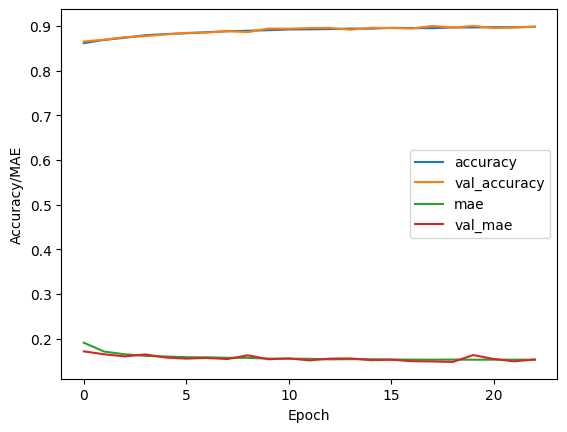

Max mae:  0.19103150069713593
Min mae:  0.15297462046146393
2573/2573 [==============================] - 3s 1ms/step - loss: 0.1750 - accuracy: 0.8983 - mae: 0.1537
Test MAE:  [0.17495711147785187, 0.8983262777328491, 0.1536678820848465]
Accuracy:  0.8983627557754517


In [ ]:
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', drop_prob= 0.05, e=100, verbose=0)
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', drop_prob= 0.1, e=100, verbose=0)
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', drop_prob= 0.2, e=100, verbose=0)
build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', drop_prob= 0.3, e=100, verbose=0)

Differ by Epoch

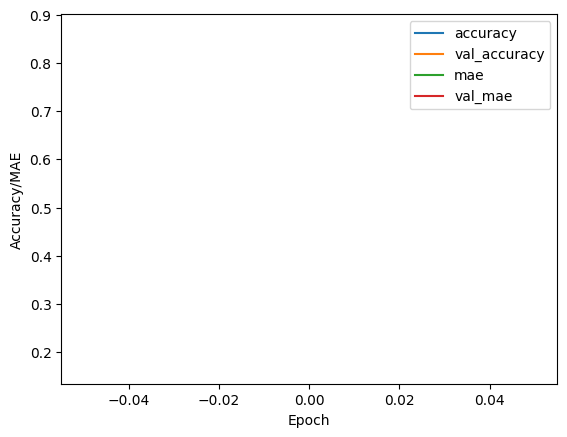

Max mae:  0.19088539481163025
Min mae:  0.19088539481163025
2573/2573 [==============================] - 3s 1ms/step - loss: 0.2121 - accuracy: 0.8668 - mae: 0.1689
Test MAE:  [0.21212944388389587, 0.8668196797370911, 0.1688968390226364]
Accuracy:  0.8569936156272888


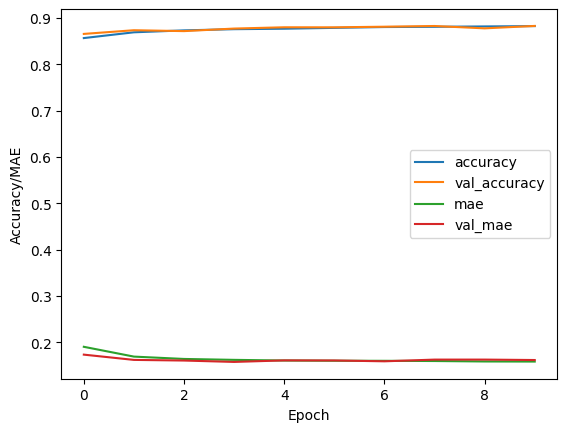

Max mae:  0.1901588886976242
Min mae:  0.1582794338464737
2573/2573 [==============================] - 3s 998us/step - loss: 0.1862 - accuracy: 0.8829 - mae: 0.1616
Test MAE:  [0.18615810573101044, 0.8829495310783386, 0.16161318123340607]
Accuracy:  0.8825365304946899


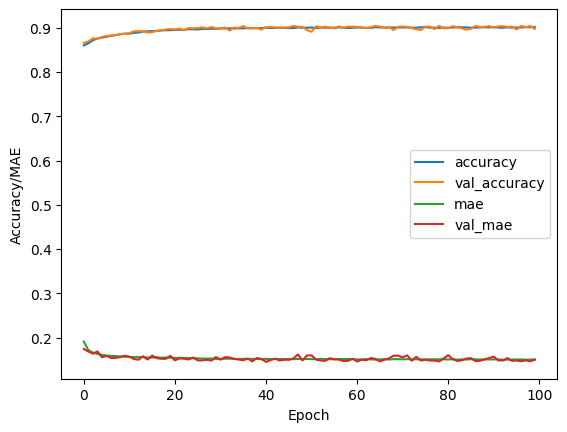

Max mae:  0.19081352651119232
Min mae:  0.14981237053871155
2573/2573 [==============================] - 3s 992us/step - loss: 0.1728 - accuracy: 0.8974 - mae: 0.1498
Test MAE:  [0.17284061014652252, 0.8973667621612549, 0.14975091814994812]
Accuracy:  0.9018486142158508


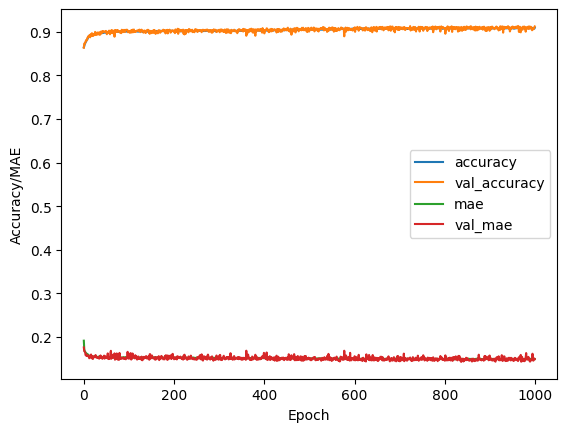

Max mae:  0.1912449598312378
Min mae:  0.14833611249923706
2573/2573 [==============================] - 2s 860us/step - loss: 0.1688 - accuracy: 0.9124 - mae: 0.1490
Test MAE:  [0.1687694638967514, 0.9123669862747192, 0.14904245734214783]
Accuracy:  0.9093183875083923


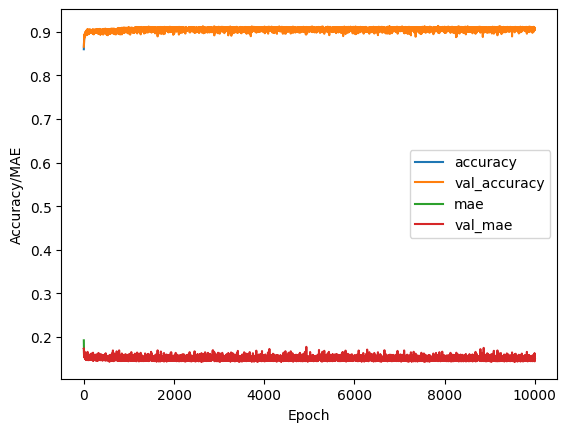

Max mae:  0.19245608150959015
Min mae:  0.14941629767417908
2573/2573 [==============================] - 3s 914us/step - loss: 0.1673 - accuracy: 0.9070 - mae: 0.1488
Test MAE:  [0.1673235297203064, 0.9070106148719788, 0.1488349884748459]
Accuracy:  0.9081645011901855


In [ ]:
#build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=1, verbose=0)
#build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=10, verbose=0)
#build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=100, verbose=0)
#build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=1000, verbose=0)
#build_and_plot(neurons=64, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, dropout=False, activation='tanh', e=10000, verbose=0)